In [9]:
!source .venv/bin/activate

In [10]:
from torchvision import datasets
import torch

data_folder = '~/data/FMNIST' 
fmnist      = datasets.FashionMNIST(data_folder, download=True, train=True)
tr_images   = fmnist.data
tr_targets  = fmnist.targets

print('jumlah_data_image: ', len(tr_images), 'jumlah_data_targets: ', len(tr_targets))
device = "cuda" if torch.cuda.is_available() else "cpu"

jumlah_data_image:  60000 jumlah_data_targets:  60000


In [11]:
from torch.utils.data import Dataset
class FMNISTDataset(Dataset):
    def __init__(self, x, y):
        x = x.float()/255       # converted the input into the floating-point number 
        x = x.view(-1,28*28)    # flattened each image into 28*28 = 748
        self.x, self.y = x, y 
    def __getitem__(self,  ix):
        x, y = self.x[ix], self.y[ix]
        return x.to(device),  y.to(device)
    def __len__(self):
        return len(self.x)
    


In [12]:
from torch.utils.data import DataLoader

def get_data():
    train = FMNISTDataset(tr_images, tr_targets)
    trn_dl = DataLoader(train,  batch_size=32, shuffle=32)
    return trn_dl

from torch.optim import SGD
import torch.nn as nn

def get_model():
    model = nn.Sequential(
        nn.Linear(28 * 28, 1000),
        nn.ReLU(),
        nn.Linear(1000, 10)
    ).to(device)
    loss_fn = nn.CrossEntropyLoss() #  cross entropy loss : loss calculation and activation function(softmax), It performs softmax internally. case multi class in ann we  not use softmax as activation function
    optimizer = SGD(model.parameters(), lr=1e-2)
    return model, loss_fn, optimizer
     

trn_dl = get_data()
model, loss_fn, optimizer = get_model()



In [13]:
def train_batch(x, y, model, opt, loss_fn):
    model.train()
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

@torch.no_grad()
def accuracy(x, y, model):
    model.eval()
    prediction = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()
     
    



In [14]:
import numpy as np

losses, accuracies = [], []
for epoch in range(5):
    epoch_losses, epoch_accuracies = [], []
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        epoch_losses.append(batch_loss)
    epoch_loss = np.array(epoch_losses).mean()
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        epoch_accuracies.extend(is_correct)
    epoch_accuracy = np.mean(epoch_accuracies)
    losses.append(epoch_loss)
    accuracies.append(epoch_accuracy)

    print("EPOCH :", epoch, "|", "LOSSES :", losses[-1], "|", "ACCURACIES :", accuracies[-1])

    


EPOCH : 0 | LOSSES : 0.8414689770857493 | ACCURACIES : 0.8049
EPOCH : 1 | LOSSES : 0.534658531610171 | ACCURACIES : 0.83415
EPOCH : 2 | LOSSES : 0.48115678575833637 | ACCURACIES : 0.82855
EPOCH : 3 | LOSSES : 0.4532125481526057 | ACCURACIES : 0.8471166666666666
EPOCH : 4 | LOSSES : 0.43400722383260726 | ACCURACIES : 0.8468833333333333


/tmp/ipykernel_37051/3569144481.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


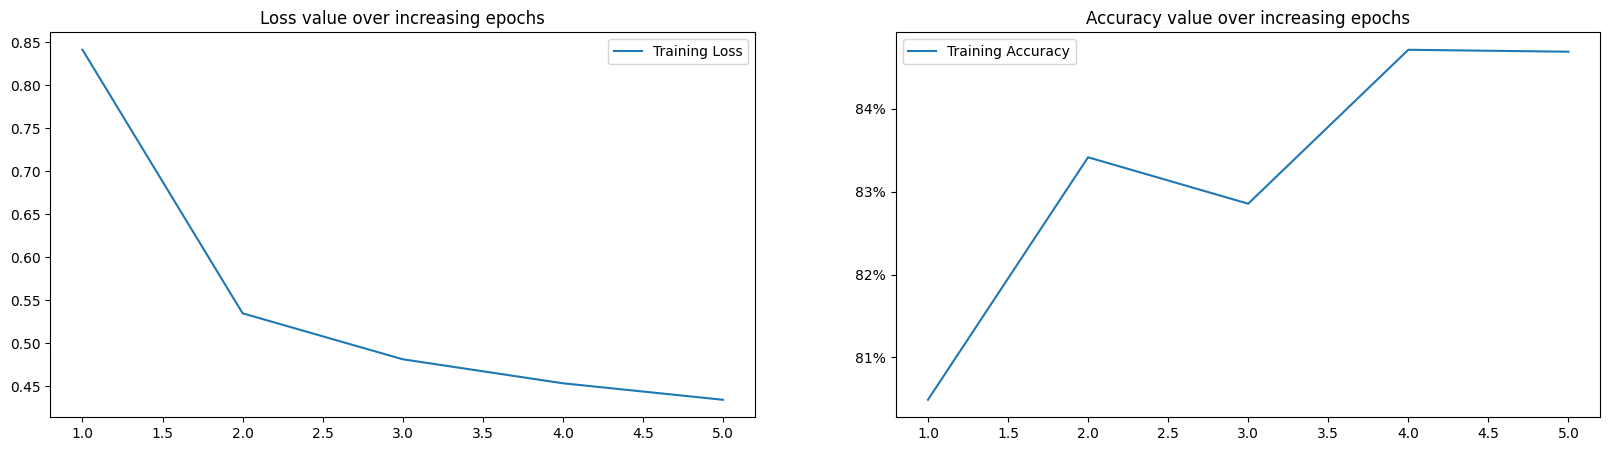

In [15]:
import matplotlib.pyplot as plt

epochs = np.arange(5)+1
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.title('Loss value over increasing epochs')
plt.plot(epochs, losses, label='Training Loss')
plt.legend()
plt.subplot(122)
plt.title('Accuracy value over increasing epochs')
plt.plot(epochs, accuracies, label='Training Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()